[2018-03-23 16:27:18.153676] INFO: system_log: rqdatac use socket ('q-rqdatad', 16003)
2016-01-04 INFO RunInfo: RunInfo({'commission_multiplier': 1, 'matching_type': MATCHING_TYPE.CURRENT_BAR_CLOSE, 'end_date': datetime.date(2017, 12, 29), 'future_starting_cash': 1000000.0, 'stock_starting_cash': 0, 'margin_multiplier': 1, 'slippage': 0, 'frequency': '1d', 'benchmark': None, 'start_date': datetime.date(2016, 1, 4), 'run_type': RUN_TYPE.BACKTEST})
2016-02-22 INFO 先平空仓 再开多仓
2016-02-22 WARN 订单被拒单: [J88] 已涨停。
2016-03-07 INFO 先平空仓 再开多仓
2016-03-07 WARN 订单被拒单: [J88] 已涨停。
2016-04-01 INFO 先平空仓 再开多仓
2016-04-01 WARN 订单被拒单: [J88] 已涨停。
2016-04-11 INFO 先平空仓 再开多仓
2016-04-11 WARN 订单被拒单: [J88] 已涨停。
2016-04-12 INFO 先平空仓 再开多仓
2016-04-12 WARN 订单被拒单: [J88] 已涨停。
2016-04-20 INFO 先平空仓 再开多仓
2016-04-20 WARN 订单被拒单: [J88] 已涨停。
2016-04-25 INFO 先平空仓 再开多仓
2016-04-25 WARN 订单被拒单: [J88] 已涨停。
2016-07-12 INFO 先平空仓 再开多仓
2016-07-12 WARN 订单被拒单: [J88] 已涨停。
2016-08-05 INFO 先平空仓 再开多仓
2016-08-08 INFO 加仓！
2016-08-08 WARN 订单被拒单: 

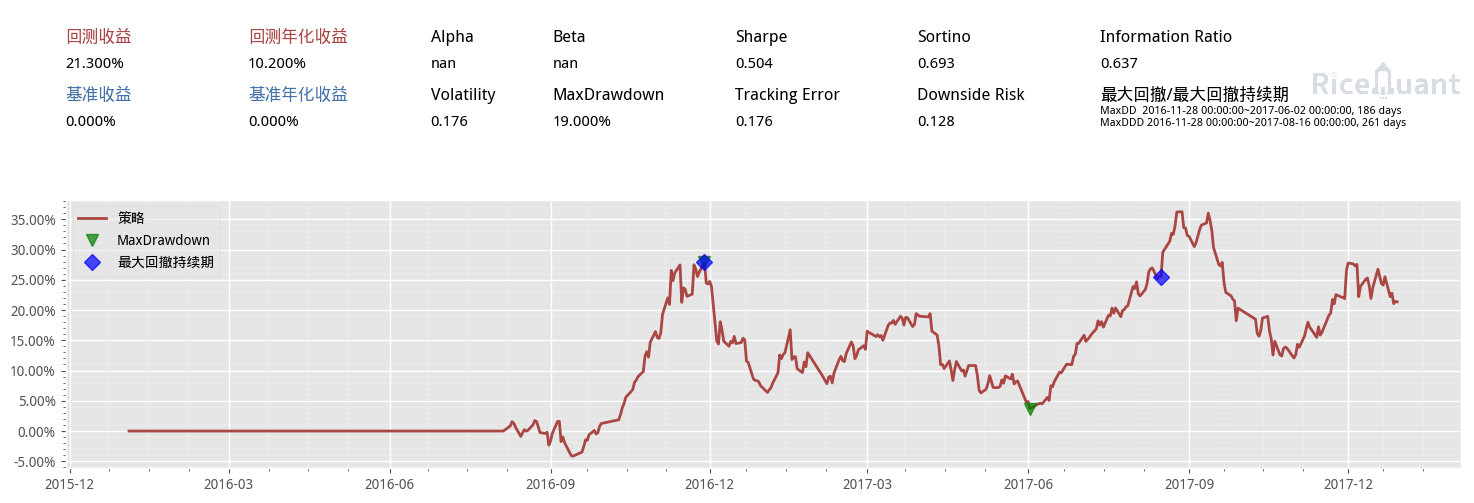

In [2]:
%%rqalpha_plus -s 20160101 -e 20180101 --account future 1000000 -fq 1d -p 
# 上述命令参数可以通过运行 %%rqalpha_plus -h 查看到
 
# 上述命令参数可以通过运行 %%rqalpha_plus -h 查看到
 
# 可以自己import我们平台支持的第三方python模块，比如pandas、numpy等。
import pandas as pd
import numpy as np
import talib as talib
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    # context内引入全局变量s1
    context.s1 = "J88"
    context.breakout_point_periods_A = 20
    context.atr_observe = 55
    # context.failsafe_breakout_point_periods_B = 55
    context.atr_periods = 20
    context.exit_periods = 10
    context.unit_max_limit = 4
    context.contract_multiplier = instruments(context.s1).contract_multiplier
    # 初始化时订阅合约行情。订阅之后的合约行情会在handle_bar中进行更新。
    subscribe(context.s1)
    # 实时打印日志
    logger.info("RunInfo: {}".format(context.run_info))


# before_trading此函数会在每天策略交易开始前被调用，当天只会被调用一次
def before_trading(context):
    pass

# 计算波动率和头寸
def get_unit(context):
    _bars_price = context.bar_price_for_atr
    _high = _bars_price['high']
    _low = _bars_price['low']
    _close = _bars_price['close']
    
    # 计算波动率 N：TR（True Range）的20日指数移动平均
    # 市场价值量波动性
    _atr = talib.ATR(_high,_low,_close,timeperiod=context.atr_periods)[-1]
    
    total_assets = context.portfolio.total_value
    # 波动性调整之后的头寸单位
    _unit = total_assets*.005/_atr/context.contract_multiplier
    
    return _atr,min(_unit,context.unit_max_limit)

# 唐奇安通道突破
# 开仓判断 20日均线突破 
def breakout_Channel(context,bar_dict):
    
    _bars_price = history_bars(context.s1,context.breakout_point_periods_A,'1d',['high','low','close'])
    
    _high_point = _bars_price['high'].max()
    _low_point = _bars_price['low'].min()
    bqt = context.portfolio.positions[context.s1].buy_quantity
    sqt = context.portfolio.positions[context.s1].sell_quantity
    
    # print("高",_high_point)
    # print("低",_low_point)
    # print("最新价",bar_dict[context.s1].last)
#     print("------------")
    
    if bar_dict[context.s1].last >= _high_point and bqt == 0:
        context.cur_point = bar_dict[context.s1].last
        context.long_open_point = bar_dict[context.s1].last
        context.command = "entry2longOpen"
    elif bar_dict[context.s1].last <= _low_point and sqt == 0:
        context.cur_point = bar_dict[context.s1].last
        context.short_open_point = bar_dict[context.s1].last
        context.command = "entry2shortOpen"
    else:
        context.command = "N"


def clear_short(context,bar_dict):
    _sig_clear = False
    if not _sig_clear:
        sqt = context.portfolio.positions[context.s1].sell_quantity
        buy_close(context.s1,sqt)
        if sqt == 0:
            print("clear short!")
            _sig_clear = True
            
def clear_long(context,bar_dict):
    _sig_clear = False
    if not _sig_clear:
        bqt = context.portfolio.positions[context.s1].buy_quantity
        sell_close(context.s1,bqt)
        if bqt == 0:
            print("clear long!")
            _sig_clear = True

def action(context):
    bqt = context.portfolio.positions[context.s1].buy_quantity
    sqt = context.portfolio.positions[context.s1].sell_quantity
    
    if context.command == "entry2longOpen":
        print("先平空仓 再开多仓")
        if sqt>0:
            clear_short(context,bar_dict)
        buy_open(context.s1,context.UNIT)
            
    elif context.command=="entry2shortOpen":
        print("先平多仓 再开空仓")
        if bqt>0:
            clear_long(context,bar_dict)
        sell_open(context.s1,context.UNIT)
        
    elif context.command =="longAdd":
        if bqt<context.unit_max_limit:
            
            buy_open(context.s1,context.UNIT)
            print("加B餐啦！")
        else:
            print("B餐加不进了！")
        
    elif context.command == "shortAdd":
        if sqt <context.unit_max_limit:
            sell_open(context.s1,min(context.UNIT,context.unit_max_limit))
            print("加S餐啦！")
        else:
            print("S餐加不进了！")
        
    elif context.command == "Longstop":
        sell_close(context.s1,min(context.UNIT,context.unit_max_limit))
        print("减B餐！")
    elif context.command == "Shortstop":
        buy_close(context.s1,min(context.UNIT,context.unit_max_limit))
        print("减S餐！")
        
    elif context.command == "LongExit":
        clear_long(context,bar_dict)
        print("B clear!")
    elif context.command == "ShortExit":
        clear_short(context,bar_dict)
        print("S clear!")
    

def add(context,bar_dict):
    
    bqt = context.portfolio.positions[context.s1].buy_quantity
    sqt = context.portfolio.positions[context.s1].sell_quantity
    # 多头 加仓 
    if bqt>0:
        context.cur_point += .5 * context.ATR
        if bar_dict[context.s1].last > context.cur_point:
            context.long_open_point = context.cur_point
            context.command = "longAdd"
        else:
            return "N"
    elif sqt>0:
        context.cur_point -= .5 * context.ATR
        if bar_dict[context.s1].last <  context.cur_point:
            context.short_open_point = context.cur_point
            context.command = "shortAdd"
        else:
            return "N"
    else:
        return "N"
    
    
def get_stoploss_point(context,bar_dict):
    bqt = context.portfolio.positions[context.s1].buy_quantity
    sqt = context.portfolio.positions[context.s1].sell_quantity
    
    if bqt>0:
        stopPoint = context.long_open_point -2 * context.ATR
        if bar_dict[context.s1].last < stopPoint:
            context.command = "Longstop"
        else:
            return "N"
    elif sqt>0:
        stopPoint= context.short_open_point +2 *context.ATR
        if bar_dict[context.s1].last > stopPoint:
            context.command = "Shortstop"
        else:
            return "N"
    else:
        return "N"

def exit(context,bar_dict):
    bqt = context.portfolio.positions[context.s1].buy_quantity
    sqt = context.portfolio.positions[context.s1].sell_quantity
    
    _price_for_exit = history_bars(context.s1,context.exit_periods,'1d',['high','low'])
    
    _long_exit_point = _price_for_exit['low'].min()
    _short_exit_point = _price_for_exit['high'].max()
    
    if bqt>0:
        if bar_dict[context.s1].last < _long_exit_point:
            context.command = "LongExit"
        else:
            return "N"
    elif sqt>0:
        if bar_dict[context.s1].last > _short_exit_point:
            context.command = "ShortExit"
        else:
            return "N"
    else:
        return "N"
        
    
def turtle_system(context,bar_dict):
    context.bar_price_for_atr = history_bars(context.s1,context.atr_observe,'1d',['high','low','close'])
    context.ATR,context.UNIT = get_unit(context)
    bqt = context.portfolio.positions[context.s1].buy_quantity
    sqt = context.portfolio.positions[context.s1].sell_quantity

# 假设当前都是空仓，判断唐奇安突破
    if bqt == 0 and sqt == 0:
        breakout_Channel(context,bar_dict)
        return
# 假设当前有仓位，判断是否止损或加仓
    elif bqt >0 or sqt>0:
        sp = get_stoploss_point(context,bar_dict)
        if sp == "N":
            # 不止损，判断是否离市
            se = exit(context,bar_dict)
            if se == "N":
                # 不止损又不离市，判断是否加仓
                sa = add(context,bar_dict)
                if sa == "N":
                    print("不干活！")
                    context.command = "N"
                    return
                else:
                    print("加仓！")
                    return
            else:
                print("溜了！")
                return
        else:
            print("止损！")
            return

    else:
        raise RuntimeError("哈？")
            

    

# 你选择的期货数据更新将会触发此段逻辑，例如日线或分钟线更新
def handle_bar(context, bar_dict):
    turtle_system(context,bar_dict)
    action(context)

    # dt = context.now
    # if (dt.hour == 14 and dt.minute >= 57) or dt.hour == 15:
    #     bqt = context.portfolio.positions[context.s1].buy_quantity
    #     sqt = context.portfolio.positions[context.s1].sell_quantity
    #     if bqt>0:
    #         print("收盘平多仓")
    #         clear_long(context,bar_dict)
    #     elif sqt>0:
    #         print("收盘平空仓")
    #         clear_short(context,bar_dict)
    #     else:
    #         return


# after_trading函数会在每天交易结束后被调用，当天只会被调用一次
def after_trading(context):
    pass